In [29]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras import layers
import os
from keras.utils import to_categorical
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc

In [27]:
def plot_acc_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, acc, 'bo', label='Training loss')
    plt.plot(epochs, val_acc, 'b', label='Validation loss')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [2]:
data = pd.read_csv('Tweets_concated_row.csv')

In [3]:
data['tweet'] = data.tweet.apply(lambda x: re.sub(r"\B@\w+", "<user>", x))
data['tweet'] = data.tweet.apply(lambda x: re.sub('http\S+\s*', '<url>', x))

In [4]:
data['tweet'] = data.tweet.apply(lambda x: x.lower())

In [5]:
y = data.gender
X = data.tweet

In [6]:
test_data = pd.read_csv('test_tweets_row.csv')
test_data['tweet'] = test_data.tweet.apply(lambda x: re.sub(r"\B@\w+", "<user>", x))
test_data['tweet'] = test_data.tweet.apply(lambda x: re.sub('http\S+\s*', '<url>', x))

In [7]:
test_data['tweet'] = test_data.tweet.apply(lambda x: x.lower())

In [8]:
X_test = test_data.tweet
y_test = test_data.gender

In [9]:
le = LabelEncoder()
y = le.fit_transform(y)
y_test = le.transform(y_test)

In [10]:
max_len = 2050
max_words = 100000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
train_seq = tokenizer.texts_to_sequences(X)

In [11]:
test_seq = tokenizer.texts_to_sequences(X_test)

In [12]:
train_seq_padded = pad_sequences(train_seq, maxlen=max_len)
test_seq_padded = pad_sequences(test_seq, maxlen=max_len)

In [13]:
glove_dir = r'D:\Machine Learning\Embeddings\glove.twitter.27B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.twitter.27B.200d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [14]:
embedding_dim = 200
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
del embeddings_index
gc.collect()

0

In [17]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
model.add(layers.GRU(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [19]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

In [20]:
history = model.fit(train_seq_padded, y,
                   epochs=30,
                   batch_size=128,
                   validation_split=0.2)

Train on 2400 samples, validate on 600 samples
Epoch 1/30
2400/2400 [==============================] - 73s 30ms/step - loss: 0.6966 - acc: 0.5108 - val_loss: 0.6860 - val_acc: 0.5283
Epoch 2/30
2400/2400 [==============================] - 70s 29ms/step - loss: 0.6810 - acc: 0.5608 - val_loss: 0.6938 - val_acc: 0.5117
Epoch 3/30
2400/2400 [==============================] - 72s 30ms/step - loss: 0.6738 - acc: 0.5763 - val_loss: 0.6862 - val_acc: 0.5317
Epoch 4/30
2400/2400 [==============================] - 68s 28ms/step - loss: 0.6626 - acc: 0.6067 - val_loss: 0.6782 - val_acc: 0.5533
Epoch 5/30
2400/2400 [==============================] - 69s 29ms/step - loss: 0.6534 - acc: 0.6237 - val_loss: 0.6716 - val_acc: 0.5850
Epoch 6/30
2400/2400 [==============================] - 63s 26ms/step - loss: 0.6411 - acc: 0.6442 - val_loss: 0.6681 - val_acc: 0.5933
Epoch 7/30
2400/2400 [==============================] - 63s 26ms/step - loss: 0.6292 - acc: 0.6479 - val_loss: 0.6624 - val_acc: 0.6083
E

In [21]:
#model1 = model

In [23]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2050, 200)         20000000  
_________________________________________________________________
gru_3 (GRU)                  (None, 2050, 32)          22368     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 20,022,401
Trainable params: 22,401
Non-trainable params: 20,000,000
_________________________________________________________________


In [ ]:
history = model.fit(train_seq_padded, y,
                   epochs=30,
                   batch_size=128,
                   validation_split=0.2)

Train on 2400 samples, validate on 600 samples
Epoch 1/30
2400/2400 [==============================] - 69s 29ms/step - loss: 0.6813 - acc: 0.5746 - val_loss: 0.6722 - val_acc: 0.6133
Epoch 2/30
2400/2400 [==============================] - 72s 30ms/step - loss: 0.6585 - acc: 0.6458 - val_loss: 0.6601 - val_acc: 0.6667
Epoch 3/30
2400/2400 [==============================] - 70s 29ms/step - loss: 0.6384 - acc: 0.6800 - val_loss: 0.6399 - val_acc: 0.6767
Epoch 4/30
2400/2400 [==============================] - 75s 31ms/step - loss: 0.6191 - acc: 0.6938 - val_loss: 0.6262 - val_acc: 0.6983
Epoch 5/30
2400/2400 [==============================] - 71s 29ms/step - loss: 0.5962 - acc: 0.7121 - val_loss: 0.6081 - val_acc: 0.6950
Epoch 6/30
2400/2400 [==============================] - 73s 30ms/step - loss: 0.5805 - acc: 0.7196 - val_loss: 0.6037 - val_acc: 0.6967
Epoch 7/30
2400/2400 [==============================] - 74s 31ms/step - loss: 0.5613 - acc: 0.7379 - val_loss: 0.5816 - val_acc: 0.7133
E

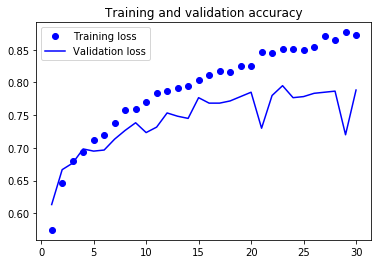

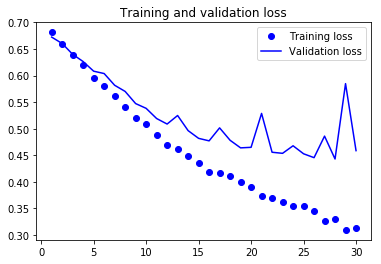

In [30]:
plot_acc_loss(history)

In [31]:
y_pred = model.predict_classes(test_seq_padded)
accuracy_score(y_pred, y_test)

0.7794736842105263